In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline
from skopt import BayesSearchCV
import skopt.space.space
from sklearn.model_selection import KFold


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")





/home/demetra/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [2]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [3]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [4]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


SVR

In [ ]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


np.random.seed(42)

ripartitions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('SVR NITOROGEN NRMSEPiqr test' + "\n")
axs = axs.flatten()
k = 0

for ripartition in ripartitions:
  
    NRMSEP = []

    print(ripartition)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'C': Continuous(1/10000,10),"epsilon":Continuous(1/100000,1)}
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=SVR(),
                                    cv=sturges,
                                    scoring=NRMSEPiqrscorer,
                                    param_grid=param_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    population_size=50,
                                    generations=100,
                                    criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best value of C: ", str(evolved_estimator.best_params_["C"]))
    print("Best value of epsilon: ", str(evolved_estimator.best_params_["epsilon"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_svr = best_model.predict(X_test)

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_svr),float(evolved_estimator.best_params_["C"]),float(evolved_estimator.best_params_["epsilon"])])

    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_svr))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_svr, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_svr)))
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","C","epsilon"]
print(tabulate(results, headers,  tablefmt="double_outline"))


In [ ]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


trials = 100
ranndom_cv = np.random.seed(777)
seeds = np.random.choice(trials, size=trials)

ripartitions = [0.25, 0.50, 0.75]

results = []  

for ripartition in ripartitions:
        
    run_name = str(ripartition) + " ripartition"
    print(run_name)
    for i in range(trials):
        result = {"Ripartition":None,
                   "Trial":None,
                    "C_bayesian":None,
                    # "C_evolutionary":None,
                      "epsilon_bayesian":None,
                     #  "epsilon_evolutionary":None,
                        "bayesian_time":None,
                          "kernel_bayesian": None,
                          "gamma_bayesian": None,
                      #    "evolutionary_time" :None,
                            "NRMSEPiqr_bayesian":None,
                       #       "NRMSEPiqr_evolutionary":None,
                                "seed": None}
            

        print("Trial:",i+1)
                
        result["Ripartition"] = ripartition
        result["Trial"] = i +1  
        result["seed"] = seeds[i]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        '''     
        param_grid = {
            'C': Continuous(1/10000,10),
            "epsilon":Continuous(1/100000,1),
            "gamma": 
            
            }
          '''
        svr_regressor =  make_pipeline(StandardScaler(),SVR())
        
        kf = KFold(n_splits=5, shuffle=True,random_state=ranndom_cv)
        #sturges = int(1 + np.log(len(X_train)))    
        '''           
        evolved_estimator = GASearchCV(estimator=svr_regressor,
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                param_grid=param_grid,
                                n_jobs=-1,
                                verbose=False,
                                population_size=10,
                                generations=10)  
        
        '''
        bayesian_estimator = BayesSearchCV(
                                svr_regressor,
                                {
                                "kernel": skopt.space.space.Categorical(["linear", "poly", "rbf", "sigmoid", "precomputed"]),
                                "gamma": skopt.space.space.Categorical(["scale", "auto"]),
                                'C':skopt.space.space.Integer(1,5000,"log-uniform"),
                                "epsilon":skopt.space.space.Real(1e-4,1,"log-uniform")},
                                cv=kf,
                                scoring=NRMSEPiqrscorer,
                                n_jobs=-1,
                                verbose= False,
                                 n_iter=15 )
            
        '''
        start_time = time.time()
        evolved_estimator.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds

        result["evolutionary_time"] = elapsed_time
        result["C_evolutionary"] = float(evolved_estimator.best_params_["C"])
        result["epsilon_evolutionary"] = float(evolved_estimator.best_params_["epsilon"])
       '''
        start_time = time.time()
        bayesian_estimator.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds

        result["bayesian_time"] = elapsed_time
        result["C_bayesian"] = float(bayesian_estimator.best_params_["C"])
        result["epsilon_bayesian"] = float(bayesian_estimator.best_params_["epsilon"])
        result["kernel_bayesian"] = bayesian_estimator.best_params_["kernel"]
        result["gamma_bayesian"] = bayesian_estimator.best_params_["gamma"]
          
           
        #result["NRMSEPiqr_evolutionary"] = NRMSEPiqr(Y_test, evolved_estimator.predict(X_test))
    

        result["NRMSEPiqr_bayesian"] =  NRMSEPiqr(Y_test,bayesian_estimator.predict(X_test))
    
        print(result)
        results.append(result)

In [ ]:


df = pd.DataFrame(results)
df.to_excel("SVR_Bayes.xlsx")


In [ ]:
from collections import Counter


svr_C = {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}
svr_epsilon= {ripartitions[0]:0,ripartitions[1]:0,ripartitions[2]:0}
svr_kernel = {ripartitions[0]:None,ripartitions[1]:None,ripartitions[2]:None}
svr_gamma= {ripartitions[0]:None,ripartitions[1]:None,ripartitions[2]:None}

#Compute the mean for every ripartition
for trial in results:
    svr_C[trial["Ripartition"]]+=trial["C_bayesian"]/trials
    svr_epsilon[trial["Ripartition"]]+=trial["epsilon_bayesian"]/trials


print("Average C: ",svr_C)
print("Average epsilon: ",svr_epsilon)

for ripartition in ripartition:
    kernels = []
    gammas = []
    for trial in results:
         kernels.append(trial["kernel_bayesian"])
         gammas.append(trial["gamma_bayesian"])
    

    counter1 = Counter(kernels)
    counter2 = Counter(gammas)

    frequencies1 = counter1.most_common()
    frequencies2 = counter2.most_common()

    svr_kernel[trial["Ripartition"]] = frequencies1[0][0]
    svr_gamma[trial["Ripartition"]] = frequencies2[0][0]

    print("Most common kernel:",svr_kernel)
    print("Most common gamma:", svr_gamma)

╔════════════════╦══════════════════╦═════════════════╦════════════════════════════╦═════╦═══════════╗
║   Test size(%) ║   Mean NRMSEPiqr ║   Var NRMSEPiqr ║   Mean Training Time (sec) ║   C ║   epsilon ║
╠════════════════╬══════════════════╬═════════════════╬════════════════════════════╬═════╬═══════════╣
║             25 ║         0.383236 ║     0.000557927 ║                  0.458729  ║  10 ║     1e-05 ║
║             50 ║         0.402206 ║     0.00019874  ║                  0.195071  ║  10 ║     1e-05 ║
║             75 ║         0.445014 ║     0.000283263 ║                  0.0517103 ║  10 ║     1e-05 ║
╚════════════════╩══════════════════╩═════════════════╩════════════════════════════╩═════╩═══════════╝


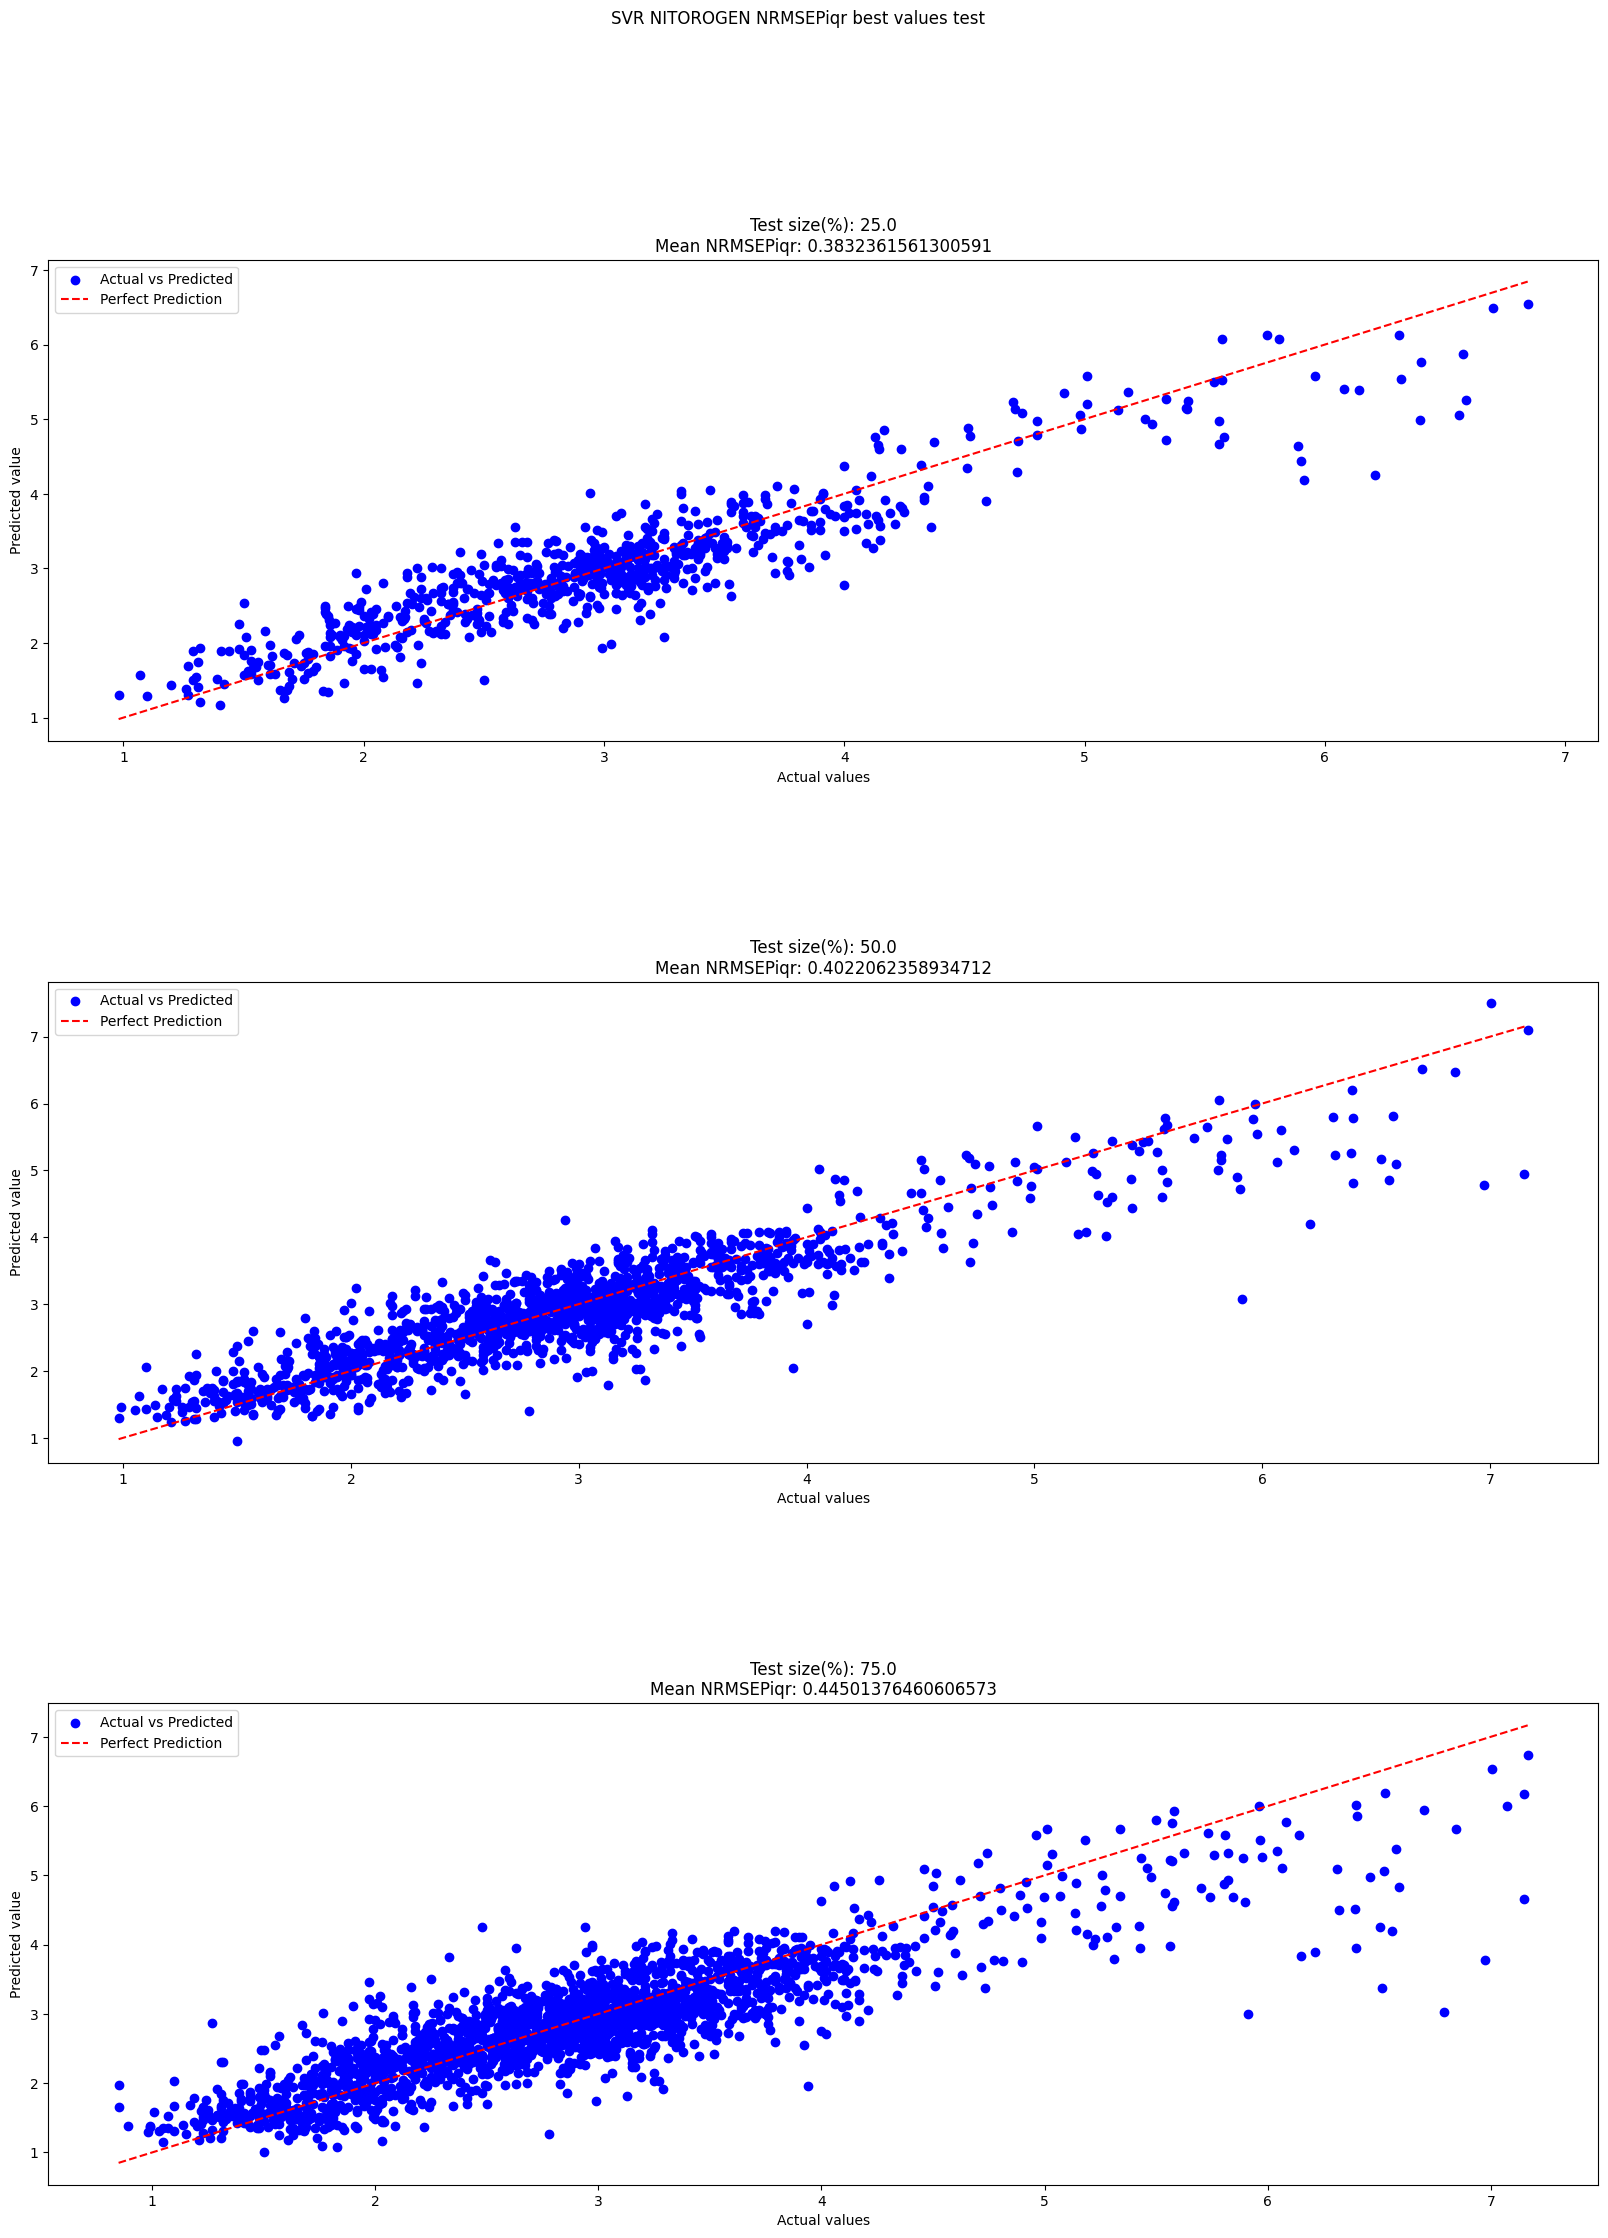

In [10]:

results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle(f'SVR NITOROGEN NRMSEPiqr best values test' + "\n")
axs = axs.flatten()
k = 0

trials = 100
random_cv = np.random.seed(777)
seeds = np.random.choice(trials, size=trials)
    

results = []
ripartitions = [0.25, 0.50, 0.75]
for C, epsilon, kernel, gamma ,ripartition in zip (svr_C.values(), svr_epsilon.values(), svr_kernel.values(), svr_gamma.values(),ripartitions):
    
    NRMSE = []
    total_time = 0
    for i in range(trials):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
        svr_regressor = make_pipeline(StandardScaler(),SVR(C=C,epsilon=epsilon, kernel=kernel, gamma=gamma))
            
        start_time = time.time()
        svr_regressor.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds
        
        # Make predictions using the testing set
        Y_pred_svr = svr_regressor.predict(X_test)

        
        NRMSE.append(NRMSEPiqr(Y_test, Y_pred_svr))
        total_time+=elapsed_time
        

    results.append([str(ripartition *100 ),np.mean(NRMSE), np.var(NRMSE),
                       total_time/trials, C, epsilon, kernel, gamma ])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(Y_test,Y_pred_svr, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                            [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}"+ "\n" + "Mean NRMSEPiqr: " + str(results[k][1]) )
    k += 1

    '''SHOW RESULTS'''

headers = ["Test size(%)", "Mean NRMSEPiqr", "Var NRMSEPiqr","Mean Training Time (sec)" ,"C" , "epsilon", "kernel", "gamma"]
print(tabulate(results, headers,  tablefmt="double_outline"))
